In [1]:
#pip install scikit-optimize

In [2]:
#pip install bayesian-optimization

In [48]:
import numpy as np
import igraph
from itertools import combinations

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import Chadoq2

from scipy.optimize import minimize

import numpy as np
import csv
import itertools
import pandas as pd
from itertools import combinations,combinations_with_replacement,permutations,product
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import argmax
import os
from mpl_toolkits import mplot3d
from matplotlib import cm


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,RationalQuadratic,DotProduct,Matern
from sklearn.metrics import r2_score

from scipy.optimize import minimize
from scipy.stats import norm


from bayes_opt import UtilityFunction
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from skopt import gp_minimize
from skopt.plots import plot_convergence,plot_gaussian_process
from bayes_opt import BayesianOptimization

In [60]:
def pos_to_graph(pos):
    rb = Chadoq2.rydberg_blockade_radius(1.0)
    g = igraph.Graph()
    N = len(pos)
    edges = [
        [m, n]
        for m, n in combinations(range(N), r=2)
        if np.linalg.norm(pos[m] - pos[n]) < rb
    ]
    g.add_vertices(N)
    g.add_edges(edges)
    return g
def quantum_loop(parameters):
    params = np.array(parameters)
    #print ("params:",params)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = Simulation(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["101100", "010011"]#["01011", "00111"] #  # MIS indexes
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()
def get_cost_colouring(bitstring, G, penalty=10):
    z = np.array(list(bitstring), dtype=int)
    A = np.array(G.get_adjacency().data)
    # Add penalty and bias:
    cost = penalty * (z.T @ np.triu(A) @ z) - np.sum(z)
    return cost


def get_cost(counter, G,penalty_val):
    cost = sum(counter[key] * get_cost_colouring(key, G, penalty = penalty_val) for key in counter)
    return cost / sum(counter.values())

def get_w_cost_colouring(bitstring, G, penalty=15):
    z = np.array(list(bitstring), dtype=int)
    A = np.array(G.get_adjacency().data)
    D= np.array(G.degree())
    #print ("degree",D)
    # Add penalty and bias:
    cost = penalty * (z.T @ np.triu(A) @ z) -z@D# np.sum(z)
    print (z@D)
    #print (cost)
    return cost


def get_w_cost(counter, G,penalty_val):
    cost = sum(counter[key] * get_w_cost_colouring(key, G) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples


def func(param, *args):
    G = args[0]
    penalty_val = args[1]
    C = quantum_loop(param)
    cost = get_cost(C, G,penalty_val)
    return cost
def convert_opt(opt_str):
    row = [int(num_i) for num_i in opt_str]
    return row
def BO(N,pnum,G, penalty_val):
    pbounds=[]
    for i in range(pnum):
        pbounds.append((8, 10))
    for i in range(pnum):
        pbounds.append((1, 3))
    res = gp_minimize(func(G, penalty_val),pbounds,random_state=1234,acq_func="LCB",n_calls=N,n_random_starts=50,noise=0.1**2)
    "x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)
    plot = plot_convergence(res)
    FIG = plot.get_figure()
    FIG.savefig('Convergence_4_pro.png')
    return(res.x)

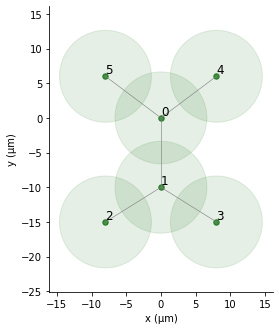

In [61]:

pos =np.array([[0.0, 0.0], 
               [0.0, -10.0],
               [-8, -15], 
               [8, -15], 
               [8, 6], 
               [-8, 6]])
#([[0,1],[0,2],[0,3],[1,4],[1,5]])
#
#pos = np.array([[0.0, 0.0], [-4, -7], [4, -7], [8, 6], [-8, 6]])

rb_r = 1.0
LAYERS = 5
# maximum number of iteration for optimization
opt_maxiter = 100
penalty_val = 10
G = pos_to_graph(pos)
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(rb_r),
    draw_graph=True,
    draw_half_radius=True,
)

In [62]:
# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)
print ("s_list:",s_list)
if LAYERS == 1:
    t_list = [t_list]
    s_list = [s_list]

for t, s in zip(t_list, s_list):
    print ("t:",t)
    print ("z:",s)
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 1.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")


s_list: s_list
t: t_list[0]
z: s_list[0]
t: t_list[1]
z: s_list[1]
t: t_list[2]
z: s_list[2]
t: t_list[3]
z: s_list[3]
t: t_list[4]
z: s_list[4]


In [63]:
guess = {
    "t": np.random.uniform(5, 10, LAYERS),
    "s": np.random.uniform(1, 5, LAYERS),
}

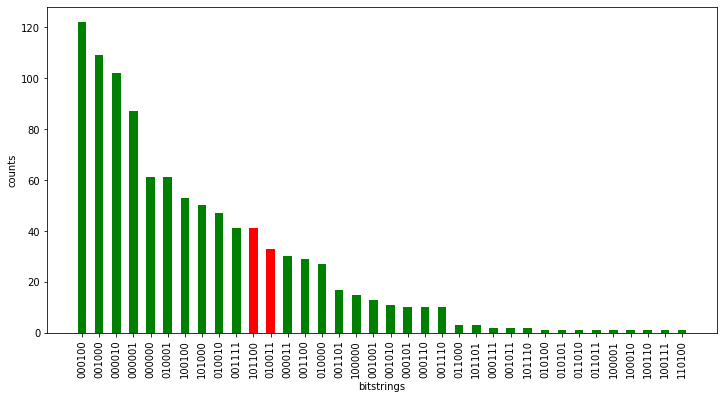

In [64]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])
plot_distribution(example_dict)


In [65]:
get_w_cost(example_dict, G,penalty_val)

0
1
1
2
1
2
2
3
1
2
2
3
2
3
3
4
3
4
4
5
4
5
4
5
6
3
4
4
4
5
6
4
5
6
6
7


-2.026

In [ ]:
res = minimize(
    func,
    args=(G, penalty_val),
    x0=np.r_[guess["t"], guess["s"]],
    method="Nelder-Mead",#"Nelder-Mead",#"L-BFGS-B", #"Powell"
    tol=1e-5,
    options={"maxiter": opt_maxiter},
)

In [ ]:
count_dict = quantum_loop(res.x)
plot_distribution(count_dict)

In [46]:
bo_res = BO(100,LAYERS,G,penalty_val)

IndexError: tuple index out of range

In [47]:
count_dict = quantum_loop(bo_res.x)
plot_distribution(count_dict)

NameError: name 'bo_res' is not defined